## Adapted (mostly comments added) from [pytorch.org](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)
js(jserences@ucsd.edu) for CSHL 2024

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
# number of 'samples' or 'trials' in each training batch
# send in >1 before backprop - usually leads to more effecient 
# training
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# y is the image label

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


#### Have a look at stuff in dataloader (X,y)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


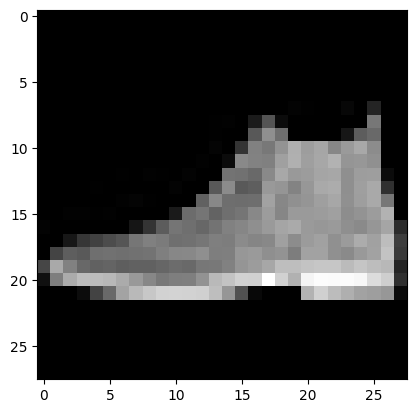

In [4]:
# image label
print(y)

# show a training image from this batch
# image is 1x24x24 - greyscale so only 1 channel
# and 24x24 pixels
img = 0
plt.imshow(X[img,0,:,:],cmap='gray')
plt.show()

#### And other relevant properties of the dataset

In [5]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Get cpu, gpu or mps (apple M1,M2,MX) device for training.


In [6]:
# query available devices 
# and save name - do in order: cuda/mps/cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    
    # init the model - main part is to make a 'Sequential' container
    # accepts an input and sends it to the first module in the container. 
    # Outputs are sequentially passed into subsequent modules (“chaining”) 
    # and an output is returned by the last module.
    # In this case we have a series of 'Linear' modules, with ReLU (rectified
    # linear unit) activation functions in between hidden layers. 
    def __init__(self):

        # init from nn.Module super class to inherit all methods
        super().__init__()
        
        # give flatten to self to shape the inputs to the sequential 
        # processing chain
        self.flatten = nn.Flatten() 

        # build the sequential container 
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    # define what to do on each forward pass of the model
    # 1) flatten input to convert 28x28 image into a vector 
    #    with 784 pixel values 
    # 2) pass input to sequential relu stack
    # 3) 
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# send the network to the desired device
model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


#### define a loss function and an optimizer
* loss function: function you are trying to minimize during training, in this case the cross entropy (difference between two probability distributions) between input logits (log-probabilities) and target...useful when training a classification problem with C classes. 
* optimizer object to store the current state and will then update the parameters based on the computed gradients (lots of different kinds...often use an Adam optimizer)

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

#### Define what happens in each training loop
* Train model (compute current weights)
* Makes predictions on the current batch of training images
* backprop the prediction error to adjust model parameters using the optimizer

In [8]:
def train(dataloader, model, loss_fn, optimizer):

    # get the number of batches 
    size = len(dataloader.dataset)
    
    # train the model object 
    # (note that there is no output because the weights, etc
    # are stored internally in this instance of the object so
    # they are modified in the object)...below you will send in 
    # new training data, compute loss, do backprop...
    model.train()

    # pass in the batch 
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)

        # Compute prediction
        pred = model(X)

        # compute difference between pred 
        # and actual label (in y)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()

        # perform a single parameter update
        optimizer.step()

        # zero out the gradient buffers before updating model params (e.g. Weights/biases)
        # because gradients accumulate so the new gradient will be 
        # combined with the old gradient which has already been used to update the model 
        # parameters and the combined gradient may point in the wrong direction
        optimizer.zero_grad()

        # print out progress...
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

#### Functon to evaluate (test) the model with held out images

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # get the model ready for evaluation (testing)
    model.eval()
    test_loss, correct = 0, 0

    # this means "do this stuff with the gradients turned off" 
    # i.e. fix the gradients during testing
    with torch.no_grad():

        # loop over images in batch
        for X, y in dataloader:

            # move the images to the current device (e.g. gpu, mps, or cpu)
            X, y = X.to(device), y.to(device)
            
            # make a prediction for each image in the current batch
            pred = model(X)

            # pass predictions and real labels into our loss function
            test_loss += loss_fn(pred, y).item()

            # keep track of how well we're doing by comparing each prediction
            # with the actual label 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # print it out
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### Train the model in 10 epochs, with each epoch containing 60000 training iterations. Then test the model after each epoch to see how training is going.

In [10]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304897  [   64/60000]
loss: 2.285691  [ 6464/60000]
loss: 2.265212  [12864/60000]
loss: 2.259078  [19264/60000]
loss: 2.232242  [25664/60000]
loss: 2.210690  [32064/60000]
loss: 2.209539  [38464/60000]
loss: 2.172639  [44864/60000]
loss: 2.177558  [51264/60000]
loss: 2.136769  [57664/60000]
Test Error: 
 Accuracy: 43.0%, Avg loss: 2.132194 

Epoch 2
-------------------------------
loss: 2.153867  [   64/60000]
loss: 2.139712  [ 6464/60000]
loss: 2.077411  [12864/60000]
loss: 2.087494  [19264/60000]
loss: 2.023602  [25664/60000]
loss: 1.977502  [32064/60000]
loss: 1.995322  [38464/60000]
loss: 1.915332  [44864/60000]
loss: 1.927176  [51264/60000]
loss: 1.841603  [57664/60000]
Test Error: 
 Accuracy: 52.9%, Avg loss: 1.839641 

Epoch 3
-------------------------------
loss: 1.892559  [   64/60000]
loss: 1.855560  [ 6464/60000]
loss: 1.730505  [12864/60000]
loss: 1.760389  [19264/60000]
loss: 1.643277  [25664/60000]
loss: 1.618183  [32064/600

#### Save the model (structure + weights and other parameters)

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


#### Load the model structure and the state dictionary (i.e. state of all layer weights, etc)

In [12]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

#### General approach for accessing wieghts via the `state_dictionary` (dict with all params for all layers)

In [13]:
sd = model.state_dict()

# print out dictionary keys
for k in sd.keys():
    print(k)

# Then can access values in the dictionary...
# e.g. weights from hidden 2
sd['linear_relu_stack.2.weight']

linear_relu_stack.0.weight
linear_relu_stack.0.bias
linear_relu_stack.2.weight
linear_relu_stack.2.bias
linear_relu_stack.4.weight
linear_relu_stack.4.bias


tensor([[-0.0090, -0.0086,  0.0087,  ...,  0.0033, -0.0352, -0.0137],
        [-0.0147, -0.0360,  0.0345,  ..., -0.0132, -0.0312, -0.0161],
        [-0.0293,  0.0251, -0.0069,  ..., -0.0293,  0.0340,  0.0213],
        ...,
        [ 0.0072, -0.0389,  0.0280,  ..., -0.0282, -0.0104,  0.0107],
        [-0.0132, -0.0167,  0.0272,  ...,  0.0435, -0.0412, -0.0356],
        [ 0.0238,  0.0243,  0.0061,  ..., -0.0242, -0.0357,  0.0052]],
       device='mps:0')